In [1]:
# 한글 폰트를 구글 코랩에서 설치하기 위한 과정
# 런타임(세션) 다시 시작을 한 후에는 이 박스의 코드는 다시 실행하지 말고 아래의 박스부터 코드를 진행함

!apt-get update &> /dev/null
!pip install --upgrade pip
!pip install gensim -q

!apt -qq -y install fonts-nanum > /dev/null #  나눔폰트 설치 (한글 출력용)
!apt-get -qq install ttf-mscorefonts-installer > /dev/null # MS 기본 글꼴 설치
!sudo fc-cache -fv > /dev/null   #  폰트 캐시 초기화
!rm ~/.cache/matplotlib -rf > /dev/null  #  matplotlib 폰트 캐시 삭제

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.




In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from google.colab import drive
drive.mount('/content/drive')

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from PIL import Image
from collections import Counter

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'     #  나눔바른고딕 폰트 파일 경로 지정
font = fm.FontProperties(fname=fontpath, size=15)  #  해당 폰트를 matplotlib에 적용할 객체 생성
plt.rc('font', family='NanumBarunGothic')  #  전체 matplotlib 폰트를 나눔바른고딕으로 설정
%config InlineBackend.figure_format = 'retina'   #  시각화 이미지 품질을 'retina'로 설정하여 선명하게 출력

%matplotlib inline

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab/공정성/df100_final1524 v2.csv', encoding='utf-8', lineterminator='\n')

df1 = df.sample(2000) # Colab 에서 유효자원을 초과하기 때문에 샘플 2,000개만 추출해서 이후 과정 진행
df1 = df1.reset_index()

df1

,index,Date,Url,Title,Content,News,Style,Year,Char,Nouns,Nouns_cleaned,Admin,Period\r
0,19881,2017. 03. 08,https://www.khan.co.kr/article/201703081732001,"흙수저· 금수저 없앨 방안?··· 정부, ‘사회이동성 영향 평가’ 도입 검토",정부가 계층간 이동성을 활성화하는 국가 차원의 중장기전략을 조만간 내놓을 전망이다....,경향,Pro,2017,232,정부 계층 이동 활성 국가 차원 중장기 전략 전망 개천 비판 최근 세태 반영 대책 ...,정부 계층 이동 활성 국가 차원 중장기 전략 전망 개천 비판 최근 세태 반영 대책 ...,Pro,3
1,15441,2016-05-11,https://www.hani.co.kr/arti/area/area_general/...,유령이 판친 ‘학교급식 입찰시스템’,투명성을 강화하기 위해 도입하고 있는 학교 급식 전자조달 시스템에 구멍이 뚫려 대책...,한겨레,Pro,2016,169,투명 강화 도입 학교 급식 전자 조달 시스템 구멍 대책 마련 요구 부산 북부 경찰서...,투명 강화 도입 학교 급식 전자 조달 시스템 구멍 대책 마련 요구 부산 북부 경찰서...,Con,2
2,10239,2016-12-28,https://www.donga.com/news/article/all/2016122...,"[나눔경영]샤롯데 봉사단, 음악 꿈나무 장기지원 나서",롯데마트는 샤롯데 봉사단이 결연시설 아동들의 재능 육성 사업에 나서고 있다. 롯데...,동아,Con,2016,148,롯데마트 샤롯데 봉사단 결연 시설 아동 재능 육성 사업 롯데마트 이달 한국사회복지협...,롯데마트 샤롯데 봉사단 결연 시설 아동 재능 육성 사업 롯데마트 이달 한국사회복지협...,Con,2
3,5687,2023.04.05,https://www.chosun.com/entertainments/broadcas...,"CJ ENM, ‘프듀 시리즈 조작’ 안준영 엠넷 PD 재입사에 사과",CJ ENM이 엠넷(Mnet) 아이돌 오디션 ‘프로듀스’ 시리즈 조작 주범인 안준영...,조선,Con,2023,215,엠넷 아이돌 오디션 프로듀스 시리즈 조작 주범 안준영 경력 입사 관련 파장 결국 사...,엠넷 아이돌 오디션 프로듀스 시리즈 조작 주범 안준영 경력 입사 파장 결국 사과 안...,Con,9
4,12691,2022-01-30,https://www.hani.co.kr/arti/politics/politics_...,이재명 “조국 사태 때 우리 잘못에 관용적 태도 취했다”,"더불어민주당 이재명 대선 후보가 28일 서울 용산구 대한의사협회를 방문, 간담회에서...",한겨레,Pro,2022,185,더불어민주당 이재명 대선 후보 서울 용산구 대한의사협회 방문 간담회 박수 공동 취재...,더불어민주당 이재명 대선 후보 서울 용산구 대한의사협회 방문 간담회 박수 공동 취재...,Con,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1780,2020.03.31,https://www.chosun.com/site/data/html_dir/2020...,"① 일회성 - ""한번만"" 못박았지만… 코로나 장기화땐 2차·3차 불가피","홍남기 경제부총리는 30일 ""긴급재난지원금은 취약 계층 소득 지원, 소비 진작, 코...",조선,Con,2020,243,홍남기 경제 부총리 긴급 재난 지원금 취약 계층 소득 지원 소비 진작 코로나 고통 ...,홍남기 경제 부총리 긴급 재난 지원금 취약 계층 소득 지원 소비 진작 코로나 고통 ...,Pro,6
1996,16708,2023-06-01,https://www.hani.co.kr/arti/economy/economy_ge...,과징금 부과된 담합 2건 중 1건은 공공분야 조달 입찰,지난 3년간 과징금이 부과된 담합 사건 2건 중 1건이 공공분야 조달 입찰에서 발생...,한겨레,Pro,2023,138,과징금 부과 담합 사건 공공 분야 조달 입찰 발생 공정위 담합 행위 적발 과징금 부...,과징금 부과 담합 공공 분야 조달 입찰 발생 공정위 담합 행위 적발 과징금 부과 가...,Con,9
1997,8384,2019-12-06,https://www.donga.com/news/article/all/2019120...,"김도읍 “청와대·민주당, 검찰 협박·수사개입 도 넘었다”",김도읍 자유한국당 의원(부산 북강서을) © News1 김도읍 자유한국당 의원(부산 ...,동아,Con,2019,127,김도읍 자유한국당 의원 부산 강서 김도읍 자유한국당 의원 부산 강서 청와대 민주당 ...,김도읍 자유한국당 의원 부산 강서 김도읍 자유한국당 의원 부산 강서 청와대 민주당 ...,Pro,5
1998,17735,2021. 07. 19,https://www.khan.co.kr/article/202107191122001,"“규제 완화” 약속한 박용진의 부동산 정책, ‘디테일’로도 차별화 노렸나",더불어민주당 대선 주자인 박용진 의원이 19일 민간 재건축·재개발 허용 등 규제 완...,경향,Pro,2021,211,더불어민주당 대선 주자 박용진 의원 민간 건축 개발 허용 규제 완화 골자 부동산 정...,더불어민주당 대선 주자 박용진 의원 민간 건축 개발 허용 규제 완화 골자 부동산 정...,Pro,7


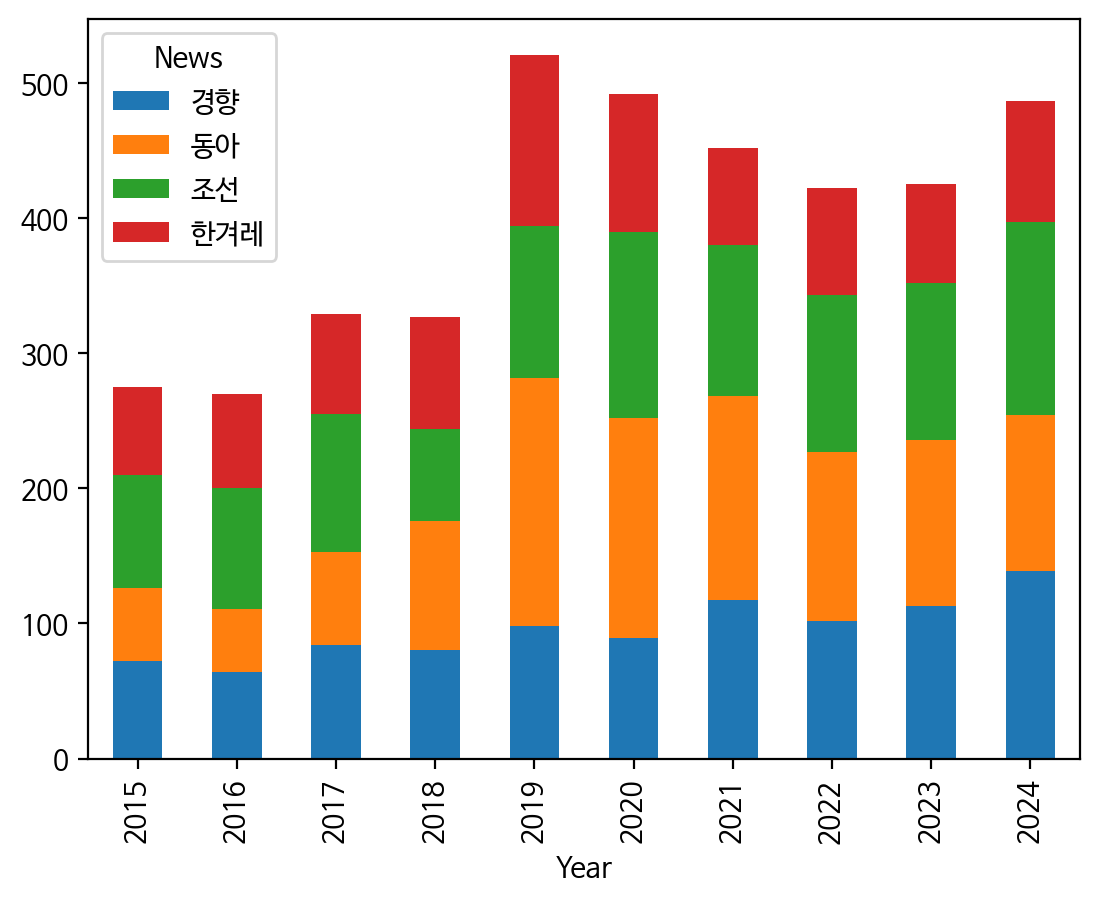

In [ ]:
# 신문사별 기사 개수 추이 확인하기

df1.groupby('News').Year.value_counts().unstack(0).plot.bar(stacked = True);

<Figure size 1200x1000 with 0 Axes>

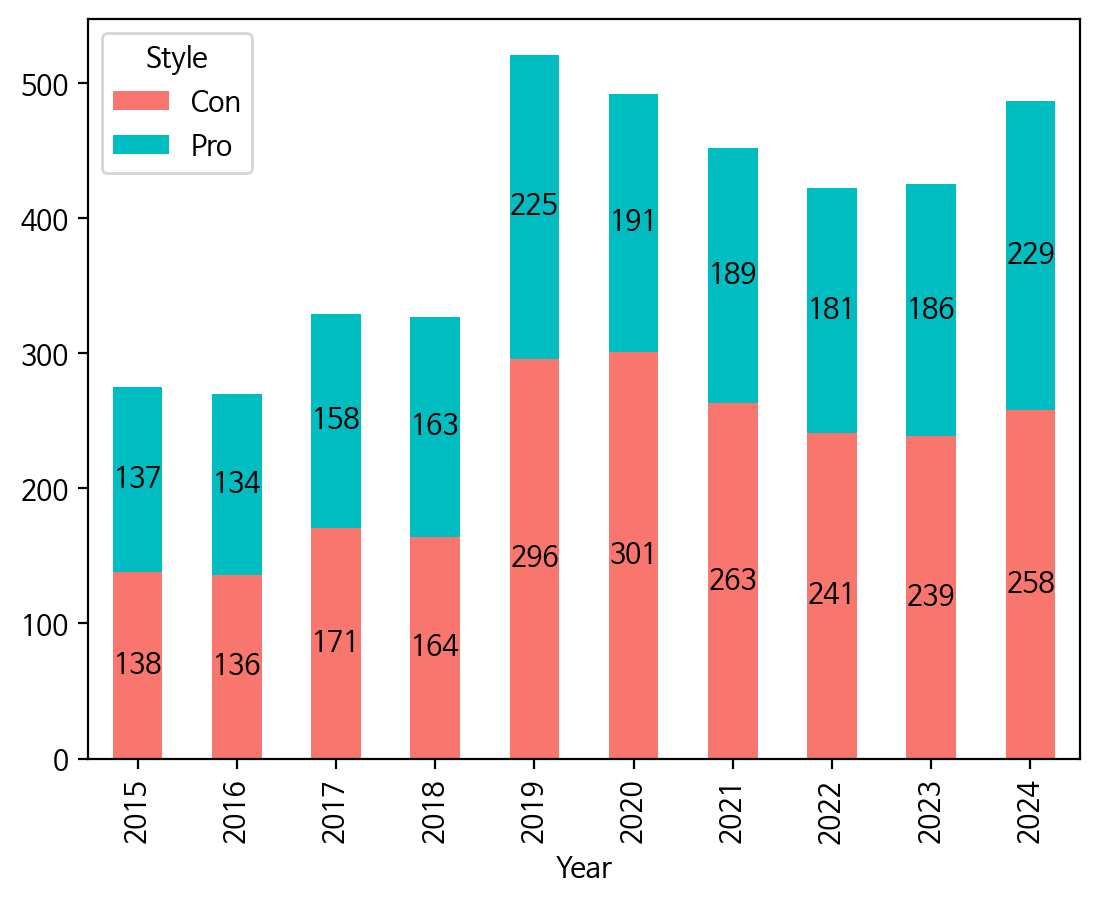

In [ ]:
# 신문사 성향별+연도별로 묶어서 개수 확인
grouped = df1.groupby('Style').Year.value_counts().unstack(0)

# 그림 사이즈 및 색상 설정
plt.figure(figsize=(12, 10))
ax = grouped.plot(kind='bar', stacked=True, color=['#F8766D', '#00BDC2'])

# 데이터값 라벨링하기
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center')

plt.show();

In [3]:
# Term-Frequency 기준(횟수만 고려)

count_vectorizer = CountVectorizer(ngram_range=(1,1),  # 유니그램 단위로 단어 분리 (단일 단어 기준)
                                   min_df=1,  # 최소 문서 등장 수 (1이면 모든 단어 유지, 희귀 단어 제거 없음)
                                   max_df=1.0)  # 최대 문서 비율 (1.0이면 모든 단어 포함, 너무 흔한 단어도 유지)

X_counts = count_vectorizer.fit_transform(df1['Nouns_cleaned'])  # 전처리된 명사 데이터로 단어 사전 학습 및 DTM 생성
feature_names_counts = list(count_vectorizer.get_feature_names_out())  # 생성된 단어 목록 추출

# Document Term Matrix 형태로 표현
counts_df = pd.DataFrame(X_counts.toarray(), columns=feature_names_counts).astype(float)  # DTM을 DataFrame으로 변환
print(len(counts_df.columns))  # 고유 단어(열)의 수 출력
counts_df

23589


,abc방송,ap통신,a매치,a형,bbc,b형,cj엔터테인먼트,cj오쇼핑,cj제일제당,dj,...,힐난,힐러리,힐링,힐만,힐머,힐스테이트,힐튼,힘겨루기,힙합,힝미
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# TF-IDF(가중치 고려)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), # (1,1)=유니그램, (1,2)=유니 or 바이그램
                                   min_df=1, # 희귀 단어 제거(문서 수 또는 비율)
                                   max_df=1.0) # 너무 흔한 단어 제거(비율 또는 문서 수)

X_tfidf = tfidf_vectorizer.fit_transform(df1['Nouns_cleaned'])
feature_names_tfidf = list(tfidf_vectorizer.get_feature_names_out())

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names_tfidf).astype(float)
tfidf_df

,abc방송,ap통신,a매치,a형,bbc,b형,cj엔터테인먼트,cj오쇼핑,cj제일제당,dj,...,힐난,힐러리,힐링,힐만,힐머,힐스테이트,힐튼,힘겨루기,힙합,힝미
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.116054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# 코퍼스별 상위 단어 확인하기

corpus_totals_counts = counts_df.sum(axis=0)  # 전체 문서에서 각 단어가 등장한 총 횟수 계산
corpus_topk_counts = corpus_totals_counts.sort_values(ascending=False).head(10)  # 가장 자주 등장한 상위 10개 단어 추출
print("Counts 기준 코퍼스 상위")
print(corpus_topk_counts)

corpus_tfidf_sum  = tfidf_df.mean(axis=0).sort_values(ascending=False).head(10)  # 중요도 높은 상위 10개 단어 추출
print("\nTF‑IDF 기준 문서 상위")
print(corpus_tfidf_sum)

Counts 기준 코퍼스 상위
공정     4068.0
수사     3551.0
검찰     3301.0
대통령    2731.0
국민     2562.0
의원     2443.0
대표     2431.0
정부     2196.0
평가     1979.0
사회     1826.0
dtype: float64

TF‑IDF 기준 문서 상위
수사     0.033549
검찰     0.030243
의원     0.025541
대통령    0.024285
대표     0.021211
방송     0.020934
국민     0.019726
공정     0.017663
장관     0.017389
후보     0.017291
dtype: float64


# 워드클라우드

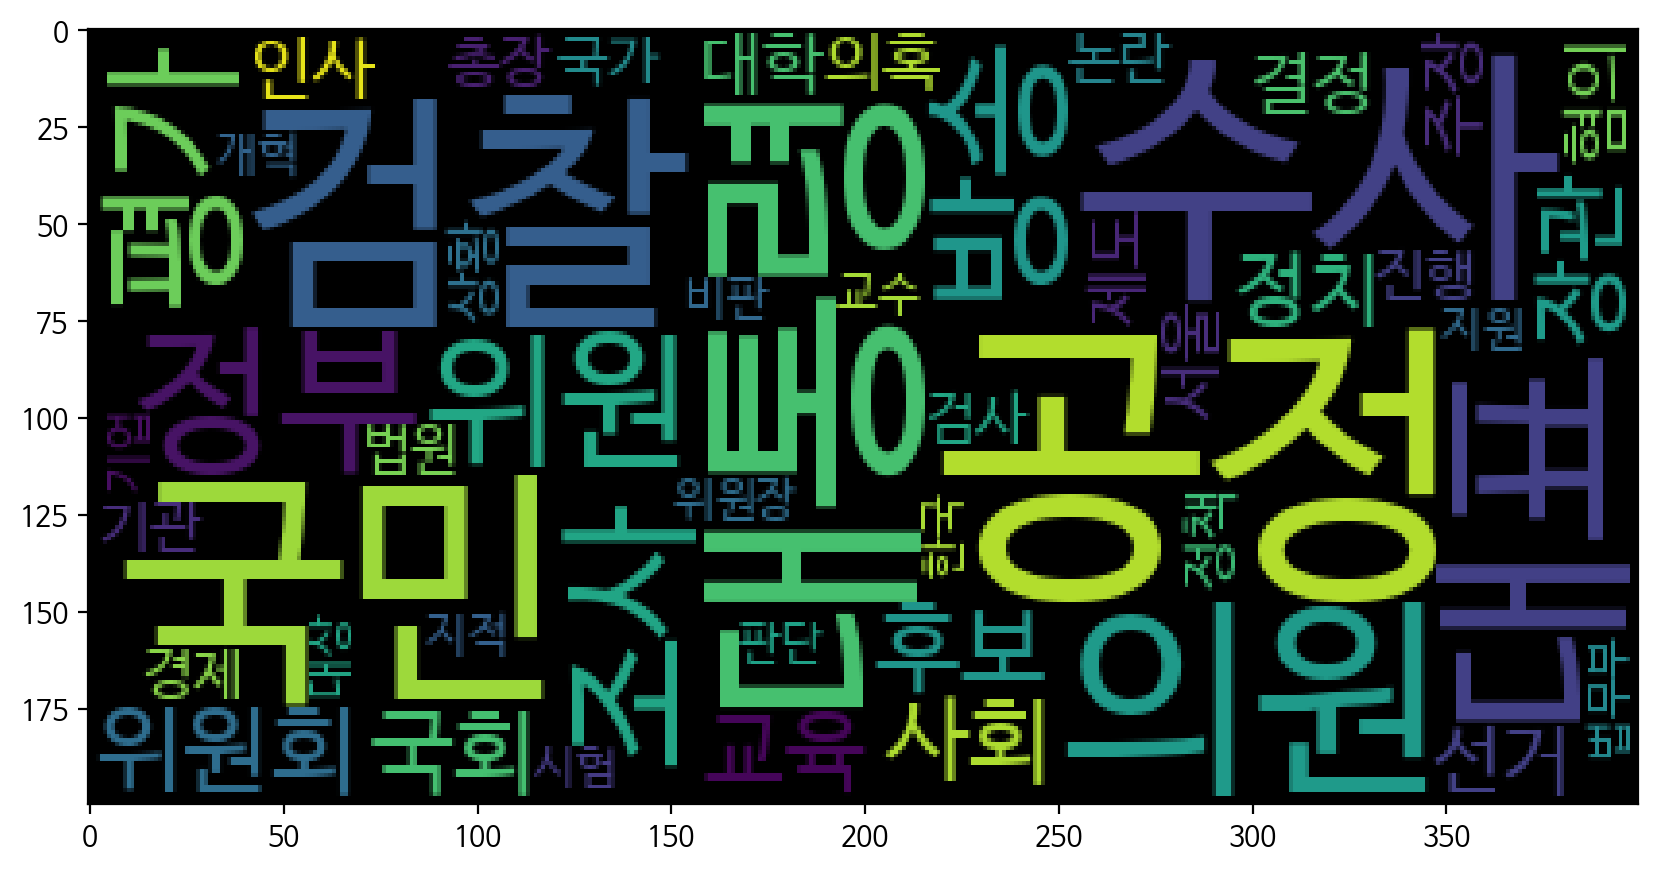

In [ ]:
vocab = count_vectorizer.get_feature_names_out()  # 단어 목록 추출
counts = np.asarray(X_counts.sum(axis=0)).ravel()  # 각 단어의 전체 등장 횟수 합산
freq = dict(zip(vocab, counts))  # 단어: 빈도 형태로 딕셔너리 구성

TOP_N = 50  # 워드클라우드에 표시할 단어 수 제한
freq = dict(sorted(freq.items(), key=lambda x: x[1], reverse=True)[:TOP_N])  # 상위 50개 단어만 추출

wordcloud = WordCloud(font_path=fontpath).generate_from_frequencies(freq)  # 단어 빈도를 기반으로 워드클라우드 생성 (한글 폰트 경로 포함)

fig = plt.figure(figsize=(10, 10))  # 출력 크기 설정
plt.imshow(wordcloud)  # 워드클라우드 이미지 표시
plt.show()  # 결과 출력

* 디테일한 파라미터 설정은 https://amueller.github.io/word_cloud/ 에서 확인가능함

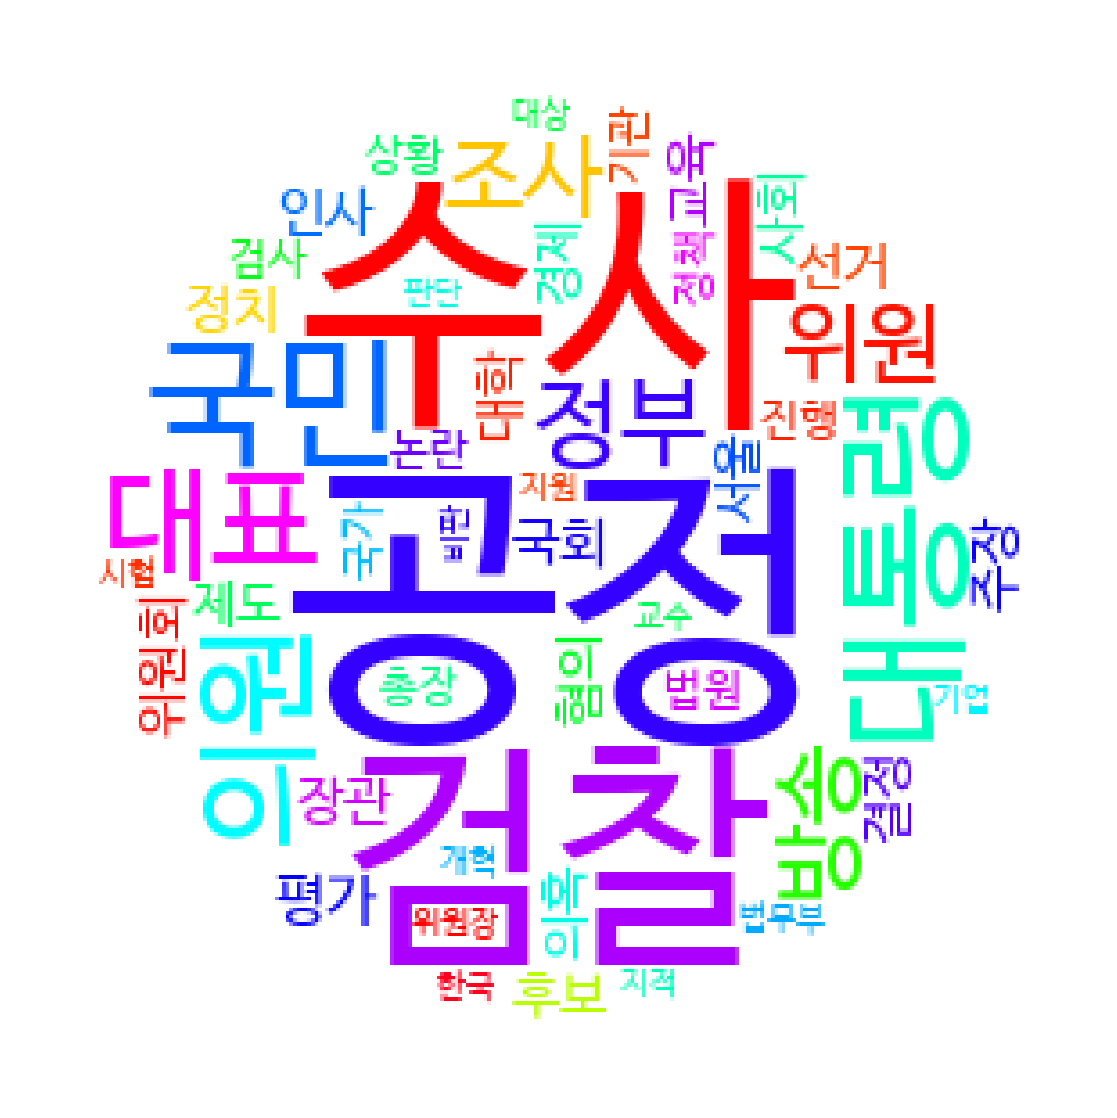

In [ ]:
x, y = np.ogrid[:300, :300]  # x와 y 좌표로 구성된 300x300 그리드 생성
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2  # 반지름 130, 중심 (150,150)인 원 바깥을 True로 설정
mask = 255 * mask.astype(int)  # True는 255(흰색), False는 0(검정색)으로 마스크 변환

# Generate the word cloud with custom parameters
wordcloud = WordCloud(
    font_path=fontpath,  # 한글 폰트 경로 지정 (예: 나눔바른고딕 등)
    background_color='white',  # 배경색 흰색
    colormap="gist_rainbow_r",  # 색상맵: 무지개 색을 반전한 컬러맵 사용
    mask=mask  # 원형 마스크 적용
).generate_from_frequencies(freq)  # 단어 빈도 딕셔너리를 기반으로 워드클라우드 생성

# Plot the word cloud
fig = plt.figure(figsize=(7, 7))  # 출력 이미지 크기 설정 (7x7 인치)
plt.imshow(wordcloud)  # 워드클라우드 이미지 표시
plt.axis('off')  # 축 및 눈금 제거
plt.show()  # 시각화 출력

--2025-10-10 08:18:23--  https://lovit.github.io/assets/figures/alice_mask.png
Resolving lovit.github.io (lovit.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to lovit.github.io (lovit.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7339 (7.2K) [image/png]
Saving to: ‘alice_mask.png.1’

alice_mask.png.1    100%[===================>]   7.17K  --.-KB/s    in 0s      

2025-10-10 08:18:23 (62.9 MB/s) - ‘alice_mask.png.1’ saved [7339/7339]



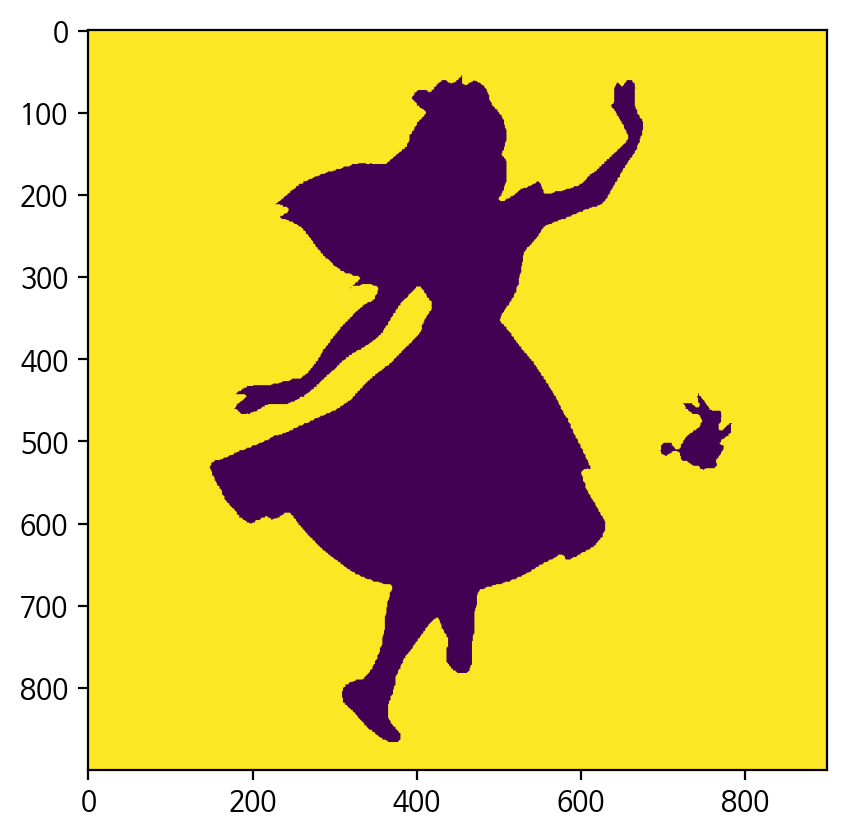

In [ ]:
# 웹페이지에서 확인가능한 이미지를 활용하고 싶은 경우

!wget https://lovit.github.io/assets/figures/alice_mask.png

mask = np.array(Image.open("alice_mask.png"))
plt.imshow(mask);

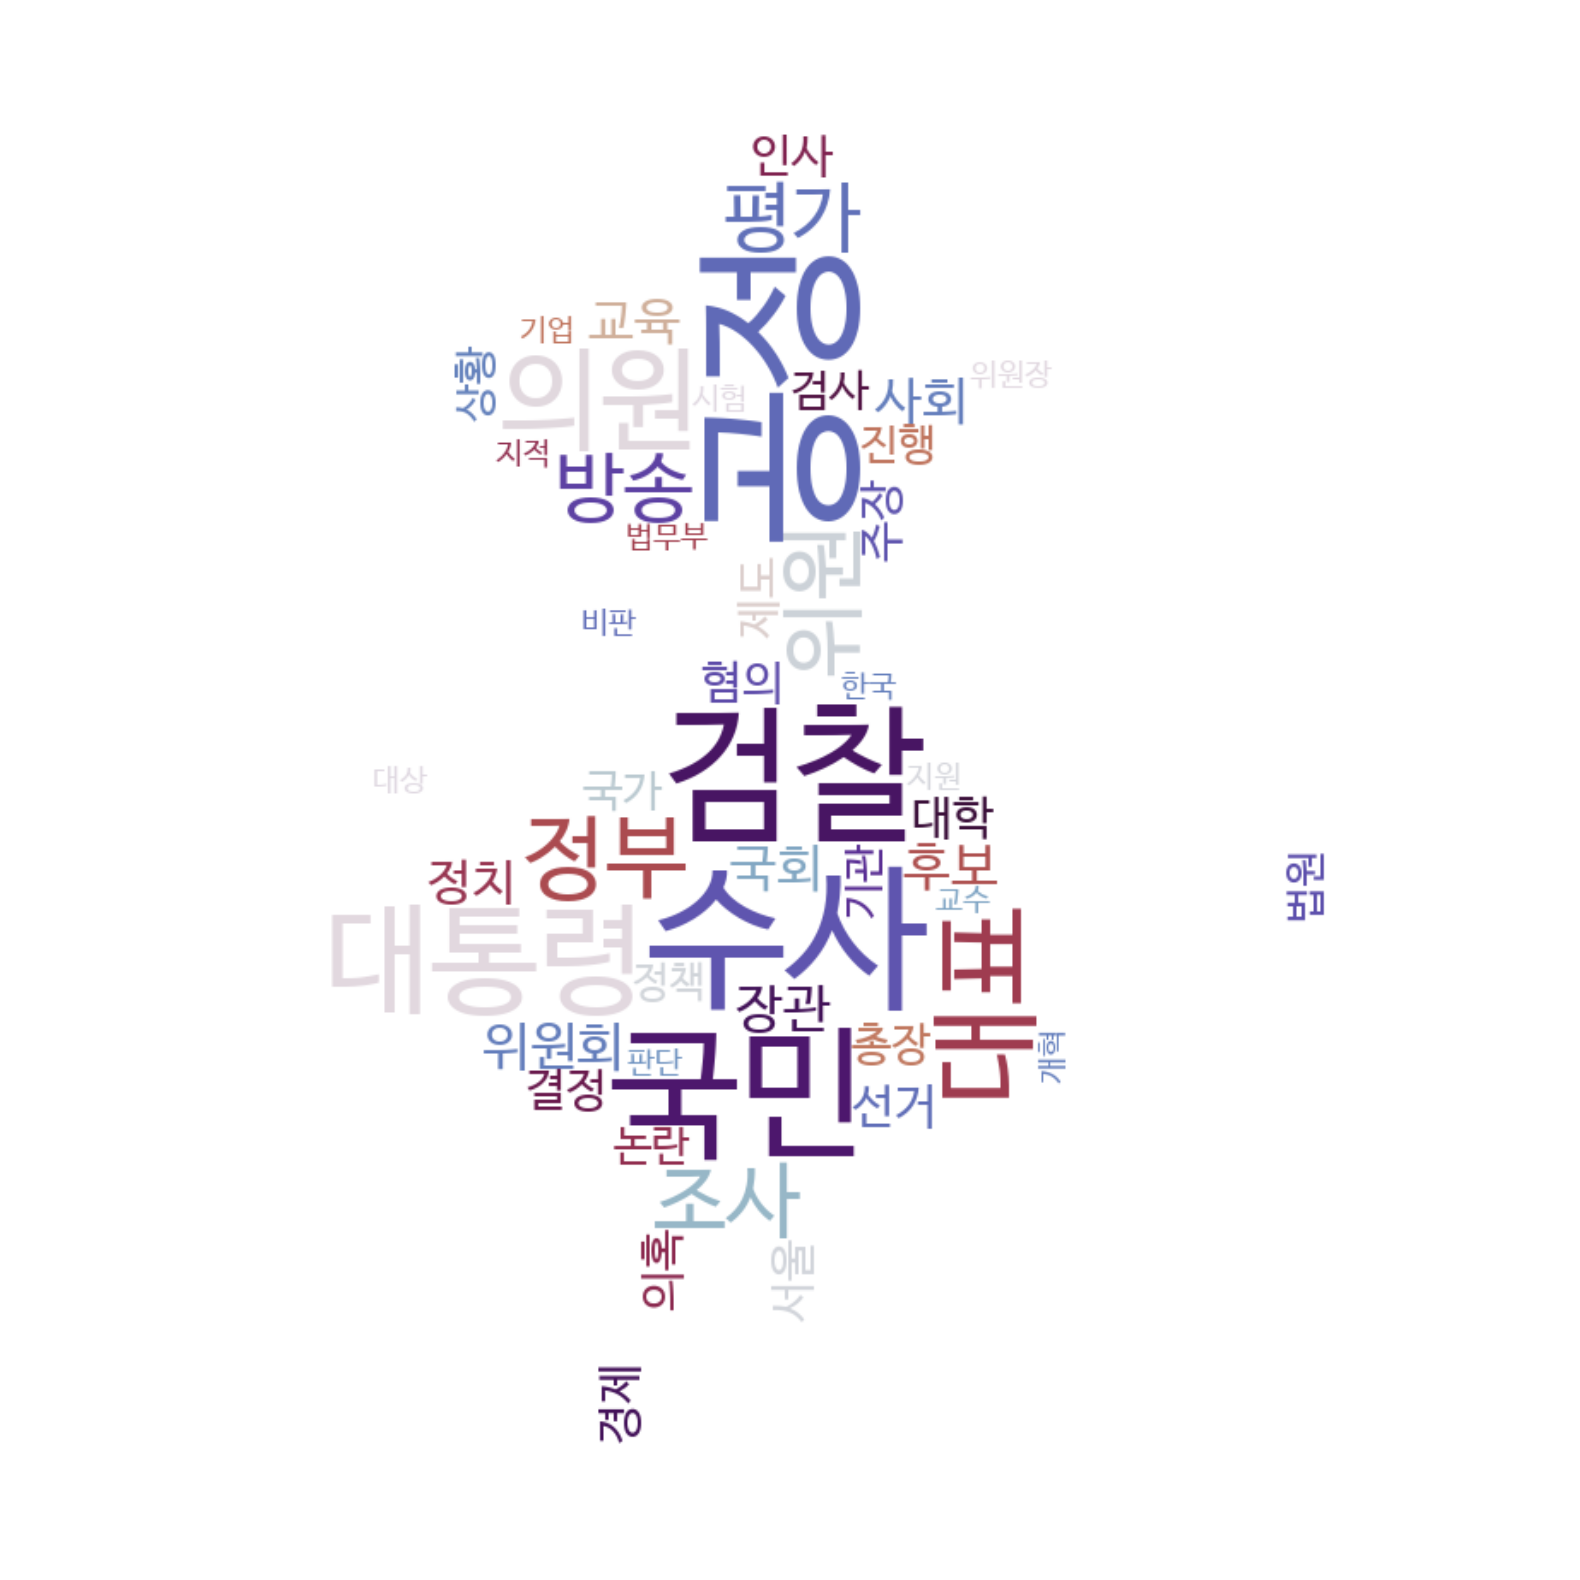

In [ ]:
wordcloud = WordCloud(
    mask=mask,  # 워드클라우드 형태를 지정하는 마스크 이미지 (예: 앨리스 모양 등)
    font_path=fontpath,  # 한글/영문 텍스트를 위한 폰트 경로 설정
    background_color='white',  # 배경색을 흰색으로 설정
    max_font_size=100,  # 가장 많이 등장한 단어의 최대 글자 크기
    colormap="twilight_r"  # 반전된 twilight 컬러맵 사용 (미려한 보라-파랑 계열)
).generate_from_frequencies(freq)  # 단어:빈도 딕셔너리를 기반으로 워드클라우드 생성

fig = plt.figure(figsize=(10, 10))  # 출력 이미지 크기 설정 (10x10 인치)
plt.imshow(wordcloud, interpolation="bilinear")  # 부드럽게 렌더링하여 워드클라우드 표시 / 참고: https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.axis('off')  # 축과 눈금 제거로 깔끔한 시각화
plt.show();  # 워드클라우드 출력

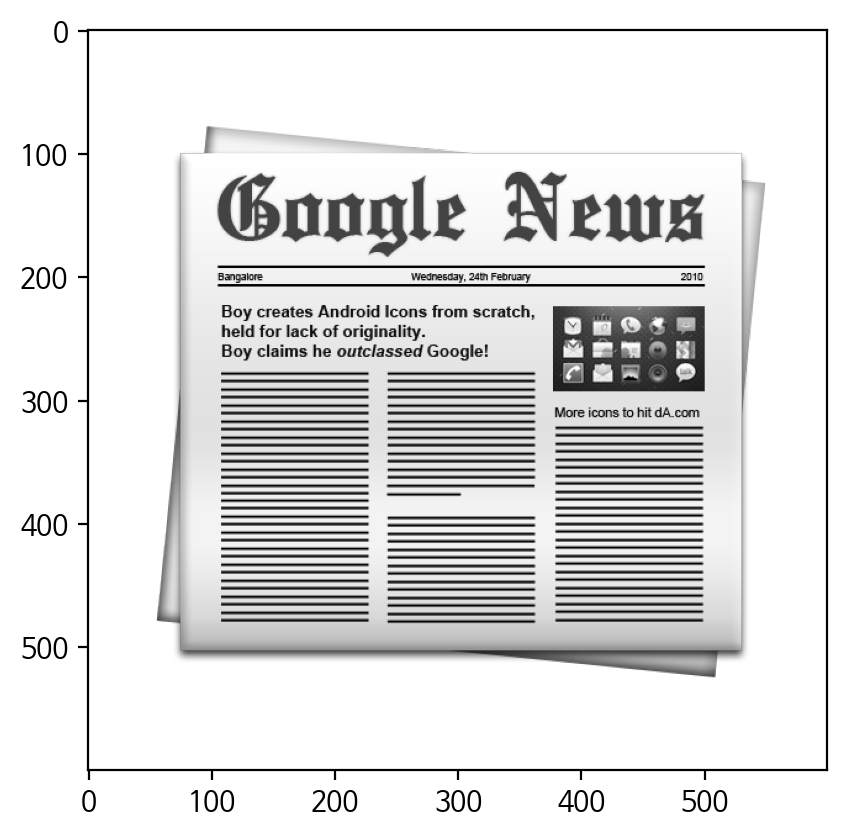

In [ ]:
# 직접 다운로드한 이미지를 활용하는 경우

mask1 = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/newspaper.png")) # You should save your own picture and reccommend png style (no background picture)
plt.imshow(mask1);

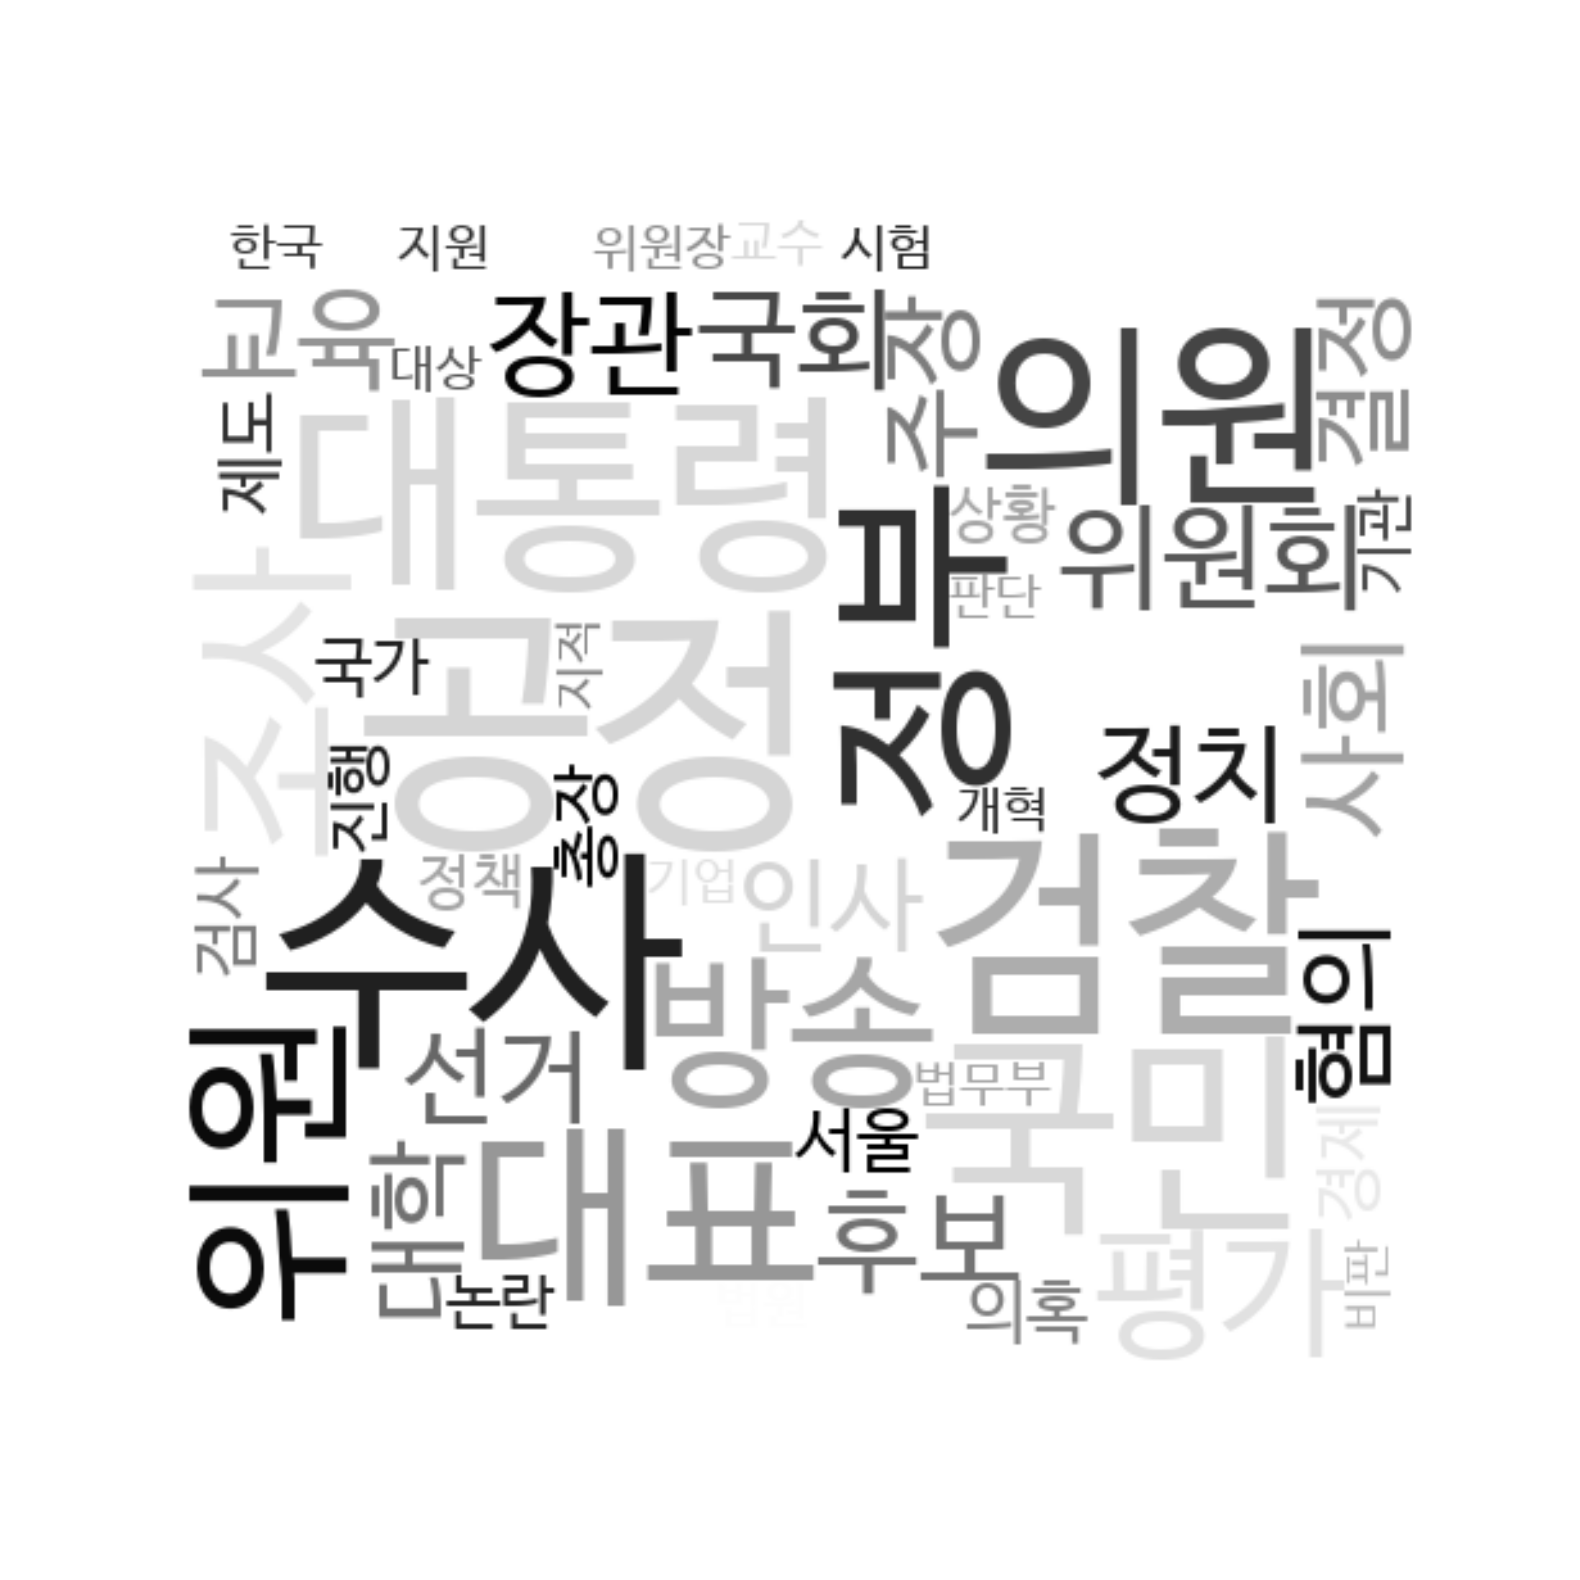

In [ ]:
wordcloud = WordCloud(
    mask=mask1,
    font_path=fontpath,
    background_color='white',
    max_font_size=100,
    colormap="gray"
).generate_from_frequencies(freq)

fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show();

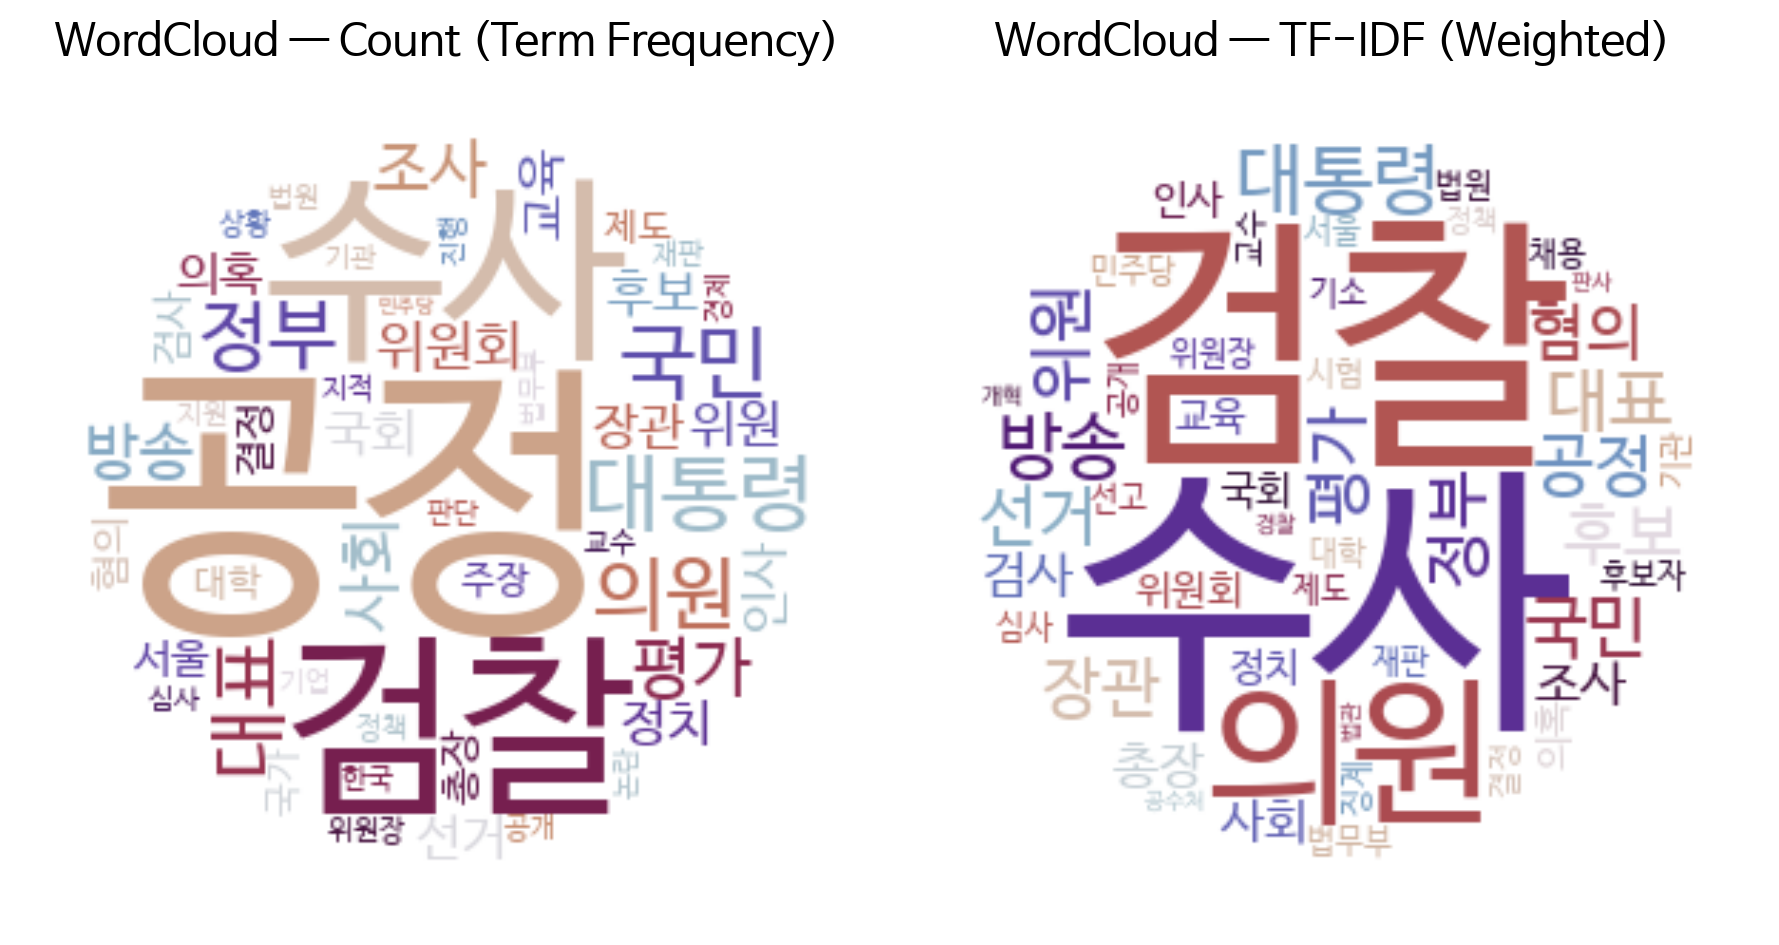

In [13]:
# ----- 1) Count 기반 빈도 사전 만들기 -----
counts = np.asarray(X_counts.sum(axis=0)).ravel()                     # 각 단어의 총 등장 횟수
freq_counts = dict(zip(feature_names_counts, counts))

# ----- 2) TF-IDF 기반 가중치 사전 만들기 -----
tfidf_vals = np.asarray(X_tfidf.mean(axis=0)).ravel()                  # 각 단어의 TF-IDF 가중치 평균
freq_tfidf = dict(zip(feature_names_tfidf, tfidf_vals))

# (선택) 최상위 N개만 사용하고 싶다면:
TOP_N = 50  # 필요에 맞게 조정
freq_counts_top = dict(sorted(freq_counts.items(), key=lambda x: x[1], reverse=True)[:TOP_N])
freq_tfidf_top = dict(sorted(freq_tfidf.items(), key=lambda x: x[1], reverse=True)[:TOP_N])

wc_counts = WordCloud(
    mask=mask,  # 워드클라우드 형태를 지정하는 마스크 이미지 (예: 앨리스 모양 등)
    font_path=fontpath,  # 한글/영문 텍스트를 위한 폰트 경로 설정
    background_color='white',  # 배경색을 흰색으로 설정
    max_font_size=100,  # 가장 많이 등장한 단어의 최대 글자 크기
    colormap="twilight_r"  # 반전된 twilight 컬러맵 사용 (미려한 보라-파랑 계열)
).generate_from_frequencies(freq_counts_top)  # 단어:빈도 딕셔너리를 기반으로 워드클라우드 생성

wc_tfidf = WordCloud(
    mask=mask,  # 워드클라우드 형태를 지정하는 마스크 이미지 (예: 앨리스 모양 등)
    font_path=fontpath,  # 한글/영문 텍스트를 위한 폰트 경로 설정
    background_color='white',  # 배경색을 흰색으로 설정
    max_font_size=100,  # 가장 많이 등장한 단어의 최대 글자 크기
    colormap="twilight_r"  # 반전된 twilight 컬러맵 사용 (미려한 보라-파랑 계열)
).generate_from_frequencies(freq_tfidf_top)  # 단어:빈도 딕셔너리를 기반으로 워드클라우드 생성

img_counts = wc_counts.generate_from_frequencies(freq_counts_top)
img_tfidf  = wc_tfidf.generate_from_frequencies(freq_tfidf_top)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
axes[0].imshow(img_counts, interpolation="bilinear")
axes[0].set_title("WordCloud — Count (Term Frequency)", fontsize=16)
axes[0].axis("off")

axes[1].imshow(img_tfidf, interpolation="bilinear")
axes[1].set_title("WordCloud — TF-IDF (Weighted)", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()